<a href="https://colab.research.google.com/github/changsin/AI/blob/main/clustering_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering on MNIST
Here is the result of clustering experiments on MNIST data. I wanted to see how robust clustering algorithm is for the data. I was hoping to see that most of the images would come to cluster into 10 groups. Unfortunately, this is not what I see. The images were too similar and the clustering algorithm could not reliably group them into neat categories whether you use cosine or Euclidean distance method.

The lesson? You need to know the dataset well and apply what works for the given dataset.

In [4]:
from keras.applications.vgg16 import VGG16
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import preprocessing  # to normalise existing X

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
dist = tfp.distributions

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.preprocessing import image
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import preprocessing  # to normalise existing X

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
dist = tfp.distributions

#Calculate similar matrics
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim,np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim/norms/norms.T)

def get_feature_maps(input):
    # i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    # x = tf.cast(i, tf.float32)
    # x = tf.keras.applications.mobilenet.preprocess_input(x)
    # #Convert to VGG input format
    # NB: This messes up the existing data so skipping it
    #   similarity measures do not seem to be affected by this.
    vgg_input = preprocess_input(input)
    

    #include_top=False == not getting VGG16 last 3 layers
    # model = VGG16(weights = "imagenet", include_top=False,
    #               input_shape = (input.shape[1], input.shape[2], 1))
    model = VGG16(weights = None, include_top=False,
                  input_shape = (input.shape[1], input.shape[2], 1))

    #Get features
    feature_maps = model.predict(vgg_input)
    # feature_maps = model.predict(input)

    return feature_maps, model

    # #Calculate similar metrics
    # features_compress = features.reshape(len(y_test), 7*7*512)
    # sim = cosine_similarity(features_compress)

# model_vgg16, feature_maps = get_feature_maps(X)

In [7]:
from skimage.transform import rescale
# image_rescaled = rescale(image, 0.25, anti_aliasing=False)

# X_train_resized = np.array([ np.resize(x, (32, 32)) for x in X_train])
X_train_rescaled = np.array([rescale(x, 32/24, anti_aliasing=False) for x in X_train])

## rescale images to 32x32

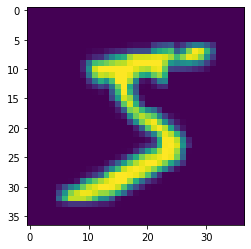

In [10]:
import matplotlib.pyplot as plt

plt.imshow(X_train_rescaled[0])

In [53]:
# This doesn't work, it resizes to (32, 32, 28)
# from skimage.transform import resize
# X_train_resized = resize(X_train, (32, 32))

<BarContainer object of 10 artists>

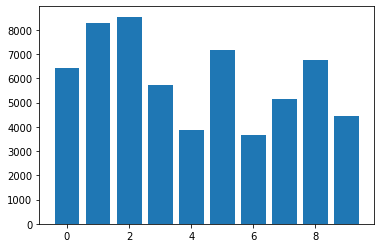

In [13]:
K = 10
# X_train_reshaped = tf.expand_dims(X_train, axis=-1)
fm_x, _ = get_feature_maps(X_train_rescaled)
# use cosine distance to find similarities
fm_x_normalized = preprocessing.normalize(fm_x.reshape(len(fm_x), -1))

X_train_clusters = KMeans(n_clusters=K, random_state=0).fit(fm_x_normalized)
histo_x, bins = np.histogram(X_train_clusters.labels_, bins=range(K + 1))

# plt.hist(bins[:-1], bins, weights=histo_x, histtype='step', label='x')
plt.bar(bins[:-1], histo_x, align='center')

<BarContainer object of 10 artists>

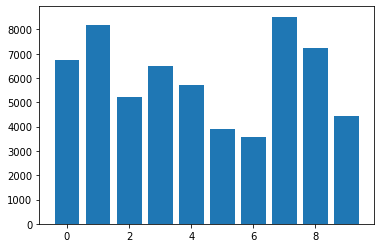

In [76]:
X_train_clusters_euclidean = KMeans(n_clusters=K, random_state=0).fit(fm_x.reshape(len(fm_x), -1))
histo_x_euclidean, bins_euclidean = np.histogram(X_train_clusters_euclidean.labels_, bins=range(K + 1))

# plt.hist(bins[:-1], bins, weights=histo_x, histtype='step', label='x')
plt.bar(bins_euclidean[:-1], histo_x_euclidean, align='center')

In [80]:
def find_clusters(X_np, K):
  fm_x, _ = get_feature_maps(X_np)
  # use cosine distance to find similarities
  fm_x_normalized = preprocessing.normalize(fm_x.reshape(len(fm_x), -1))

  clusters_x = KMeans(n_clusters=K, random_state=0).fit(fm_x_normalized)
  histo_x, bins = np.histogram(clusters_x.labels_, bins=range(K + 1))

  # plt.hist(bins[:-1], bins, weights=histo_x, histtype='step', label='x')
  plt.bar(bins[:-1], histo_x, align='center')

  return clusters_x
def to_cluster_ids(bins, labels):
  cluster_dict = dict()
  for cluster_id in bins:
    cluster_dict[cluster_id] = np.where(labels == cluster_id)[0]
  return cluster_dict

def to_clusters_dict(X, y, K):
  X_clusters = find_clusters(X, K)
  X_cluster_ids = to_cluster_ids(range(K), X_clusters.labels_)

  X_dict = {}
  y_dict = {}
  for id in range(K):
    ids = X_cluster_ids[id]
    X_dict[id] = X[ids]
    y_dict[id] = y[ids]

  return X_dict, y_dict

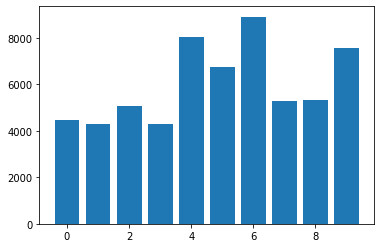

In [82]:
X_train_dict_euc, y_train_dict_euc = to_clusters_dict(X_train_rescaled, y_train, K)

In [67]:

import matplotlib.patches as patches

def create_patch_rectangle(y, color):
  # width = y[2] - y[0]
  # height = y[3] - y[1]
  # return patches.Rectangle((y[0], y[1]),
  #                           width, height,
  #                           edgecolor=color, fill=False)
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)
def plot_images(X, y, limit=10):
  fig = plt.figure(figsize=(20,40))

  # The number of images for plotting is limited to 50
  end_id = len(y) if len(y) < limit else limit

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    plt.title("{}".format(y[i]))
    plt.imshow(np.clip(image, 0, 1))
# plot_images(X_train_d[0], y_train_d[0])

In [24]:
X_train_dict, y_train_dict = to_clusters_dict(X_train, y_train, K, X_train_clusters)

In [73]:
from collections import Counter

for key, val in y_train_dict.items():
  print(Counter(val))

Counter({3: 3189, 5: 1845, 8: 806, 0: 287, 6: 102, 2: 88, 9: 86, 7: 27, 1: 6, 4: 3})
Counter({4: 2983, 9: 2356, 7: 1628, 5: 500, 2: 293, 3: 200, 8: 142, 6: 123, 0: 63, 1: 5})
Counter({7: 3509, 9: 2540, 4: 2048, 8: 169, 5: 110, 0: 64, 2: 45, 3: 41, 6: 14, 1: 2})
Counter({1: 3037, 5: 998, 8: 456, 7: 284, 6: 250, 4: 224, 9: 180, 3: 127, 2: 125, 0: 43})
Counter({2: 3491, 3: 174, 8: 65, 7: 35, 6: 24, 1: 22, 4: 19, 9: 10, 0: 5, 5: 4})
Counter({1: 3626, 3: 652, 7: 596, 6: 549, 5: 430, 9: 421, 8: 346, 2: 280, 4: 223, 0: 30})
Counter({0: 3162, 5: 176, 6: 101, 9: 52, 2: 51, 3: 42, 8: 34, 7: 20, 4: 18})
Counter({6: 4492, 2: 194, 4: 160, 5: 103, 0: 88, 8: 52, 3: 33, 7: 10, 9: 9, 1: 2})
Counter({8: 3661, 3: 1109, 5: 1082, 2: 326, 9: 188, 7: 126, 6: 120, 0: 50, 1: 42, 4: 38})
Counter({0: 2131, 2: 1065, 3: 564, 5: 173, 6: 143, 4: 126, 8: 120, 9: 107, 7: 30})


In [84]:
from collections import Counter

for key, val in y_train_dict_euc.items():
  print(Counter(val))

Counter({2: 4057, 3: 197, 8: 73, 0: 42, 4: 21, 7: 21, 9: 19, 5: 15, 1: 13, 6: 7})
Counter({1: 2921, 8: 408, 5: 292, 4: 140, 9: 127, 7: 127, 2: 121, 6: 71, 3: 65, 0: 11})
Counter({0: 4590, 2: 188, 9: 75, 6: 52, 5: 48, 7: 45, 8: 35, 3: 17, 4: 8})
Counter({6: 2811, 4: 597, 2: 469, 5: 124, 9: 67, 8: 61, 0: 60, 7: 56, 3: 38, 1: 3})
Counter({8: 2004, 4: 1830, 5: 1558, 9: 1336, 7: 618, 3: 240, 2: 224, 0: 184, 6: 36, 1: 8})
Counter({3: 3459, 5: 1261, 8: 1238, 9: 281, 2: 202, 0: 158, 7: 79, 4: 44, 6: 35, 1: 8})
Counter({6: 2617, 5: 1854, 3: 1590, 8: 1532, 0: 810, 2: 301, 4: 93, 9: 52, 1: 40, 7: 23})
Counter({1: 3724, 9: 297, 3: 253, 6: 212, 7: 202, 2: 172, 8: 171, 4: 127, 5: 112, 0: 31})
Counter({7: 4641, 9: 410, 2: 94, 3: 76, 8: 35, 4: 25, 0: 23, 5: 21, 1: 5, 6: 2})
Counter({9: 3285, 4: 2957, 7: 453, 8: 294, 3: 196, 5: 136, 2: 130, 6: 75, 1: 20, 0: 14})


In [42]:
ms = np.array([ [np.round(np.mean(y), 2), np.round(np.std(y), 2)] for id, y in y_train_dict.items()])

In [85]:
ms_euc = np.array([ [np.round(np.mean(y), 2), np.round(np.std(y), 2)] for id, y in y_train_dict_euc.items()])

In [44]:
ms[:, 1]

array([1.99, 2.32, 1.99, 2.69, 1.04, 2.77, 1.98, 1.18, 2.29, 2.3 ])

In [50]:
len(X_train_dict)

10

<BarContainer object of 10 artists>

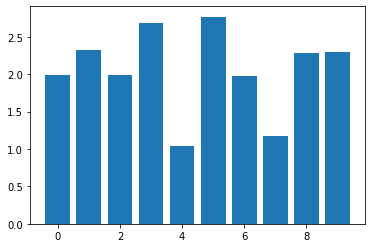

In [55]:

# plt.bar(bins[:-1], ms[:, 0], align='center')
plt.bar(bins[:-1], ms[:, 1], align='center')

<BarContainer object of 10 artists>

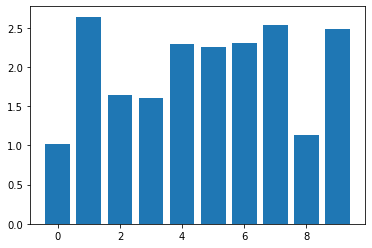

In [86]:
plt.bar(bins[:-1], ms_euc[:, 1], align='center')

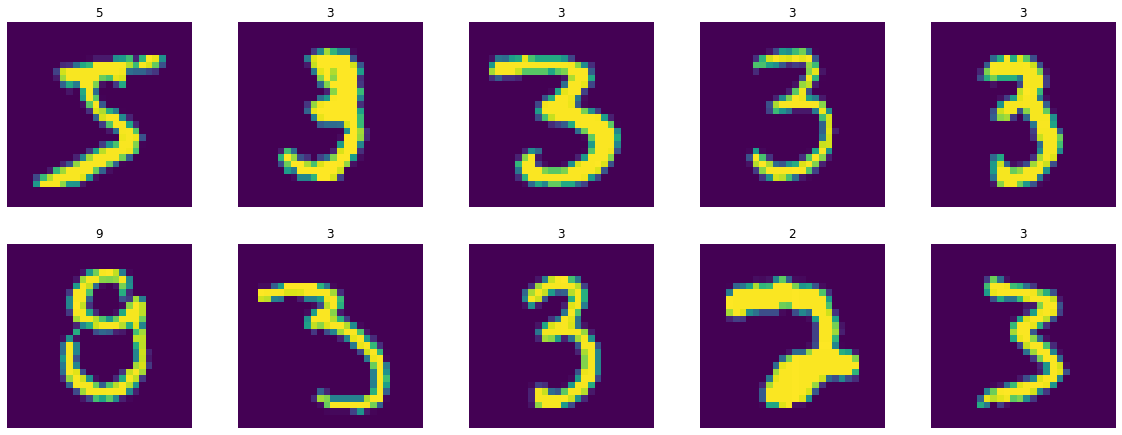

In [68]:
plot_images(X_train_dict[0], y_train_dict[0])

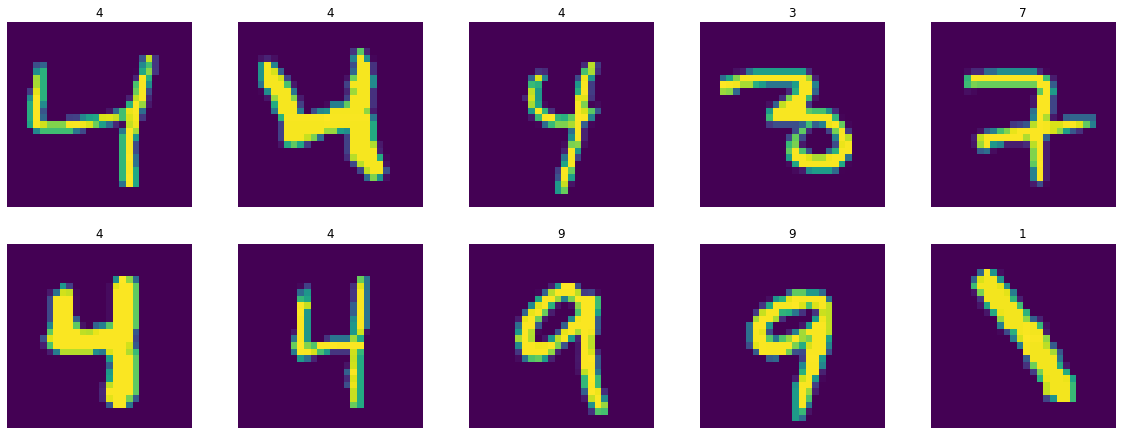

In [69]:
plot_images(X_train_dict[1], y_train_dict[1])

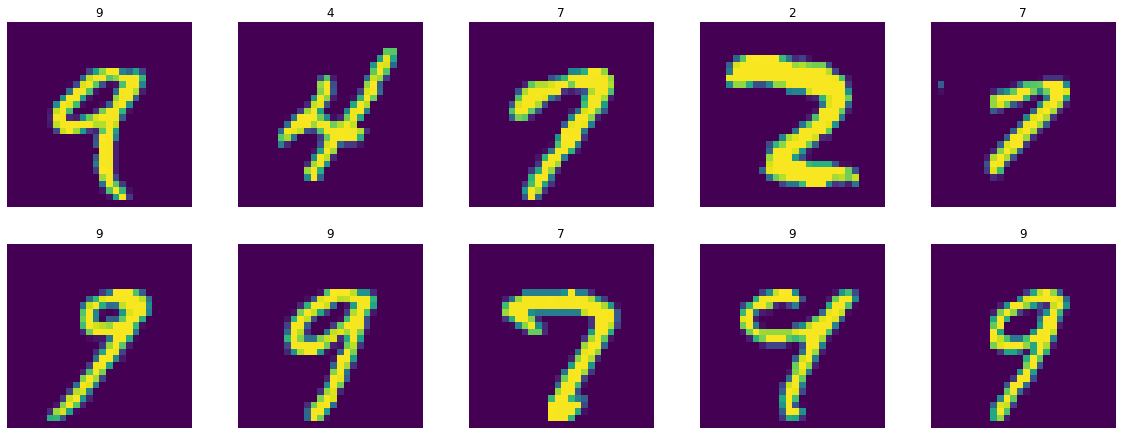

In [70]:
cluster_id = 2
plot_images(X_train_dict[cluster_id], y_train_dict[cluster_id])

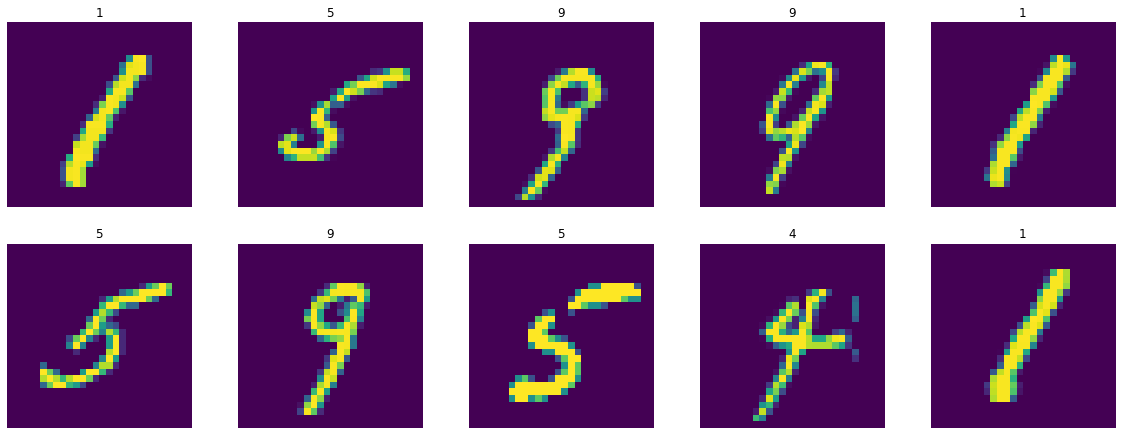

In [71]:
cluster_id = 3
plot_images(X_train_dict[cluster_id], y_train_dict[cluster_id])